In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from pathlib import Path
import sys
import torch

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [81]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    df["Confidence"] = data["confidence"]
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["Truth_value"] = data["truth"]
        df["Truth"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"P({y_labels[i]}|x)"] = data["probabilities"][:,i]

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"]

    # Could be some NaNs
    print(f"Dropping {len(df[df.isnull().any(axis=1)])} rows of NaNs")
    df = df.dropna()

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
    
    return df

In [82]:
def plot_results(df, weight_key, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[weight_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if "Error_blue" in df.keys():
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=weight_key, 
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size="Error_blue", size_norm = (0.1, 0.3), sizes=(10, 200),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=weight_key, 
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                            palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [83]:
# Setup

#MCMC constants
n_samples = 1200
#n_cal = [250, 1000, 2000, 3000, 4000, 5000]
n_cal = [250, 500]#, 1000, 1250, 1500, 1750, 2000]
n_chains = 10
n_plots = len(n_cal)

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
x_labels = ["x1", "x2"]

# Read files
folderpath = "../inferno/calibrate"
train_n = 5000

truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_200_nr1MC_200"
trainfile = f"train_n_50000_{tag}"
# FIX
calfile=f"analytical_solution_cal_n_2000_{tag}_nxMC_200_nr1MC_100"
testfile=f"analytical_solution_test_n_10000_{tag}_nxMC_200_nr1MC_100"
gridfile=f"analytical_solution_x1_x2_grid_{tag}_nxMC_200_nr1MC_100"

if polar:
    analysis_folders = [f"{calfile}/nsamples-1200_nchains-{n_chains}_ncal-{n_cal[i]}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{calfile}/nsamples-1200_nchains-{n_chains}_ncal-{n_cal[i]}" for i in range(n_plots)]

gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
cal_data = pd.read_csv(f"../analytical/results/{calfile}.csv")
test_data = pd.read_csv(f"../analytical/results/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_given_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_given_x"]/truth_data["P_x"]

test_dfs = [0]*n_plots
grid_dfs = [0]*n_plots

for i in range(n_plots):
    df_test = process_data(testfiles[i], y_labels, x_labels)
    df_grid = process_data(gridfiles[i], y_labels, x_labels, test=True)
    test_dfs[i] = df_test
    grid_dfs[i] = df_grid

# Key to use for plotting
weight_key = f"P({y_labels[1]}|x)"

Dropping 7 rows of NaNs
Dropping 5 rows of NaNs
Dropping 7 rows of NaNs
Dropping 5 rows of NaNs


In [107]:
test_data["red"] = test_data["P_red_given_x"]
test_data["blue"] = test_data["P_blue_given_x"]
test_data["Inferred_color"] = test_data[["red", "blue"]].idxmax(axis=1)
test_data

0


,color,x1,x2,a1,a2,r1,r2,r_x,a_x,class,P_red_and_x,P_blue_and_x,P_x,P_red_given_x,P_blue_given_x,Inferred_color,red,blue
0,red,4.637181,11.350187,0.935784,1.553757,11.837233,3,12.260921,1.182936,0,0.000229,0.000159,0.000388,0.589898,0.410102,red,0.589898,0.410102
1,red,10.042744,10.382106,0.682262,0.612850,11.887063,3,14.444543,0.802012,0,0.000215,0.000041,0.000256,0.839372,0.160628,red,0.839372,0.160628
2,blue,-5.605532,11.920284,1.943990,0.295500,10.273541,3,13.172515,2.010363,1,0.000237,0.000091,0.000328,0.723147,0.276853,red,0.723147,0.276853
3,blue,-1.477669,-14.679668,4.577589,0.170343,11.788505,3,14.753853,4.612066,1,0.000205,0.000033,0.000238,0.862314,0.137686,red,0.862314,0.137686
4,blue,-9.945727,8.379890,2.213879,1.781017,13.296149,3,13.005386,2.441433,1,0.000237,0.000101,0.000338,0.700778,0.299222,red,0.700778,0.299222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,red,0.596807,9.253463,1.318706,2.526894,11.560692,3,9.272689,1.506390,0,0.000141,0.000269,0.000409,0.343304,0.656696,blue,0.343304,0.656696
9996,blue,-6.404741,6.863661,1.997287,1.496279,8.674995,3,9.387787,2.321621,1,0.000141,0.000275,0.000416,0.337806,0.662194,blue,0.337806,0.662194
9997,blue,-11.277142,2.093363,2.757517,0.865739,9.295702,3,11.469791,2.958053,1,0.000209,0.000218,0.000427,0.490148,0.509852,blue,0.490148,0.509852
9998,red,8.927445,11.836816,0.898653,3.012991,17.796208,3,14.825974,0.924606,0,0.000202,0.000032,0.000234,0.864278,0.135722,red,0.864278,0.135722


Text(0.5, 0.98, 'Analytical solution. Number of datapoints: 500')

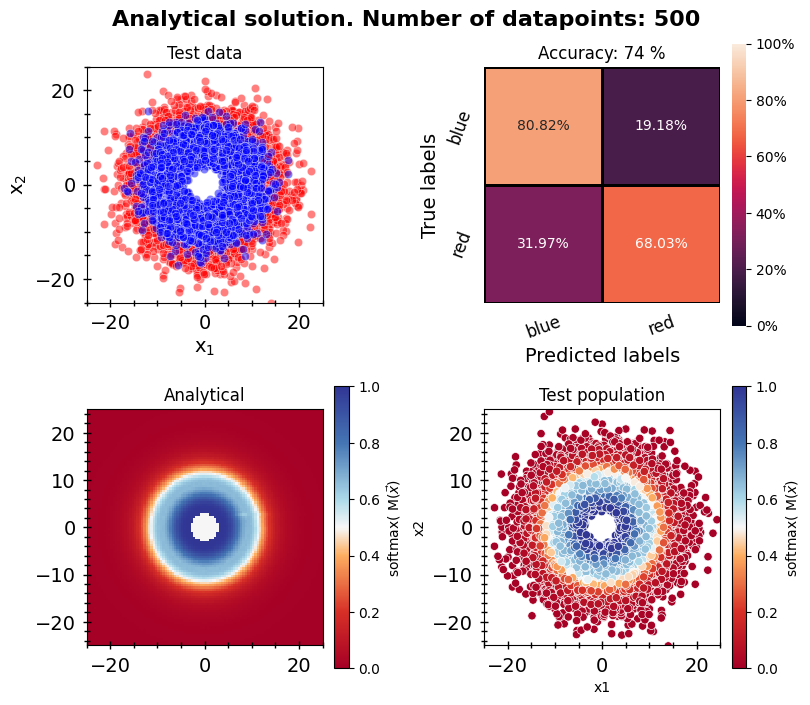

In [99]:

# Plot animation

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
#plot data
axs[0][0] = plot_data(test_data[0:train_n], axs[0][0], "Test data")
axs[0][1] = plot_conf_matrix(test_data, "color", "Inferred_color", ["blue", "red"], axs[0][1])
axs[1][0] = plot_results(truth_data, "P_blue_given_x", axs[1][0], "Analytical", grid=True)
axs[1][1] = plot_results(test_data, "P_blue_given_x", axs[1][1], "Test population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Analytical solution. Number of datapoints: {n_cal[i]}", size=16, fontweight="bold")

#plt.show()
    

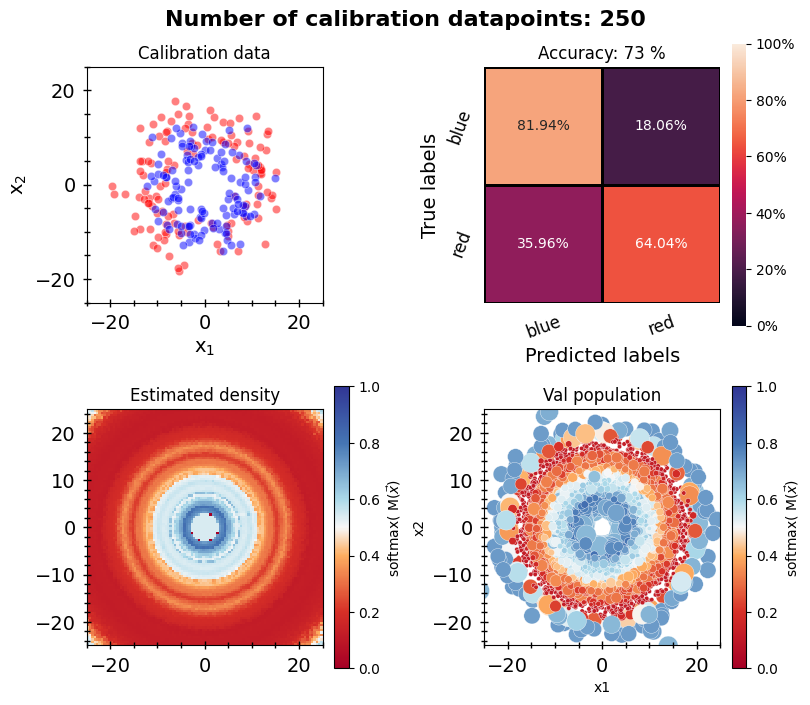

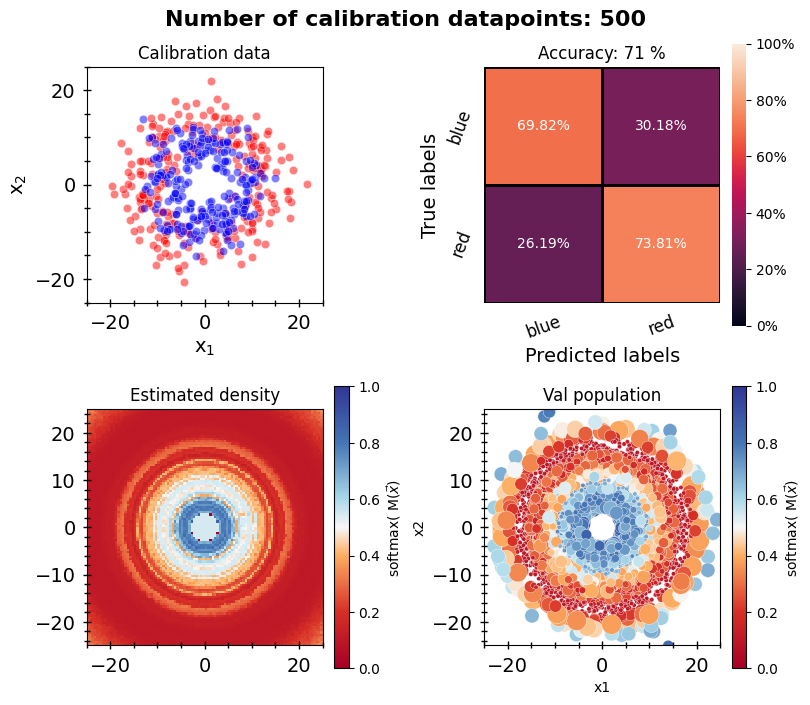

In [100]:

for i in range(n_plots):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_data(cal_data[0:n_cal[i]], axs[0][0], "Calibration data")
    axs[0][1] = plot_conf_matrix(test_dfs[i], "Truth", "Inferred_color", ["blue", "red"], axs[0][1])
    axs[1][0] = plot_results(grid_dfs[i], weight_key, axs[1][0], "Estimated density", grid=True)
    axs[1][1] = plot_results(test_dfs[i], weight_key, axs[1][1], "Val population")
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

    fig.suptitle(f"Number of calibration datapoints: {n_cal[i]}", size=16, fontweight="bold")

#plt.show()
    

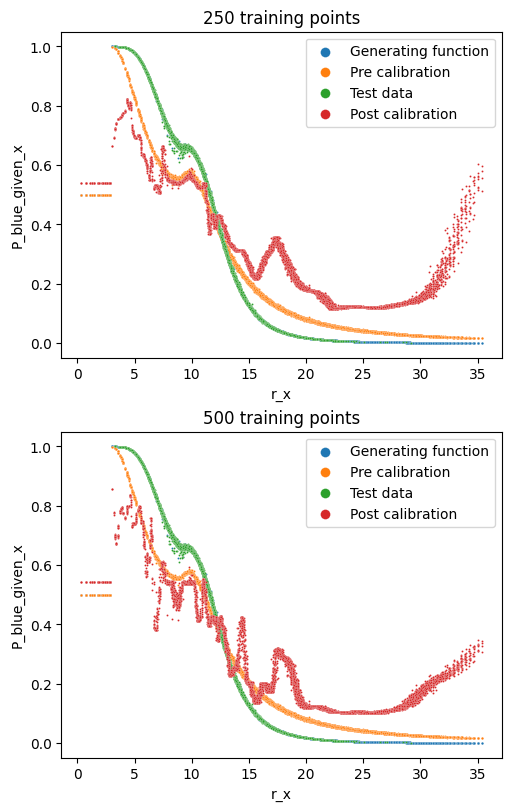

In [106]:
fig, axs = plt.subplots(nrows=len(n_cal), ncols=1, figsize= (5, 4*len(n_cal)), layout="constrained")
for i in range(len(n_cal)):
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[i], label="Generating function")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=2, ax = axs[i], label = "Pre calibration")
    sn.scatterplot(test_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[i], label = "Test data")
    sn.scatterplot(grid_dfs[i], x="r_x", y="P(blue|x)", s=2, ax = axs[i], label = "Post calibration")
    axs[i].set_title(f"{n_cal[i]} training points")
    axs[i].legend(markerscale=5)


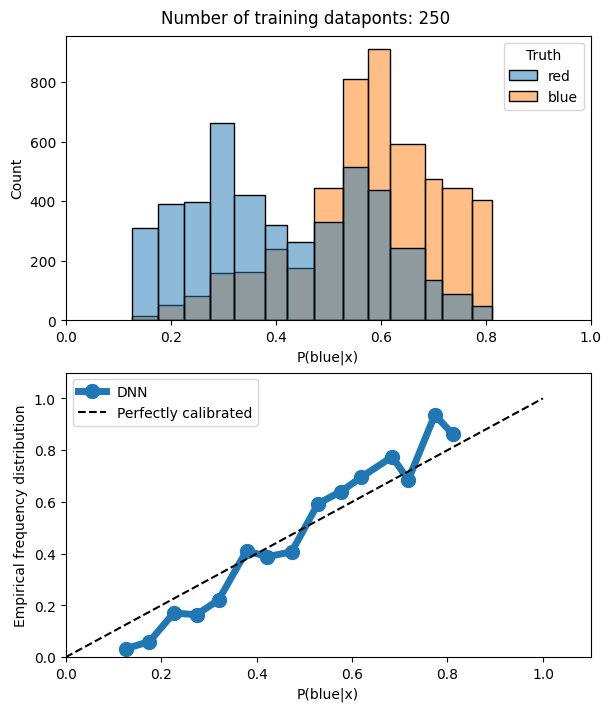

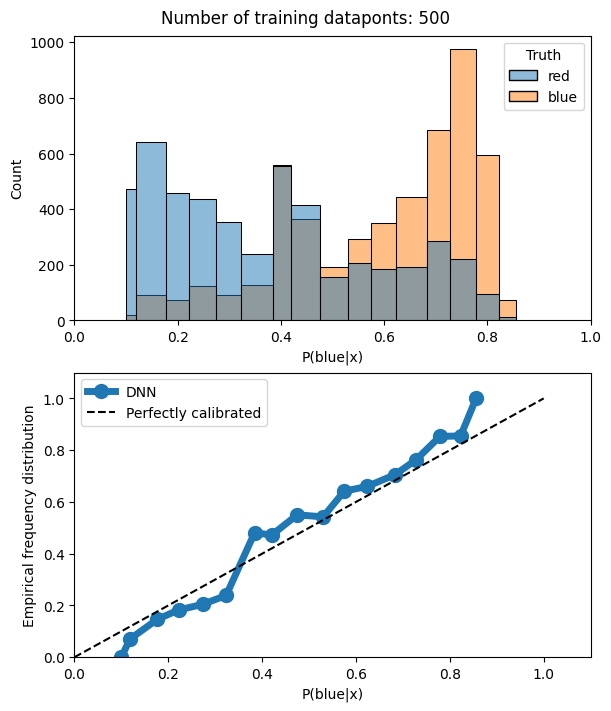

In [87]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(len(n_cal)):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["Truth_value"], test_dfs[i]["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of training dataponts: {n_cal[i]}")

Text(0, 0.5, 'Probability')

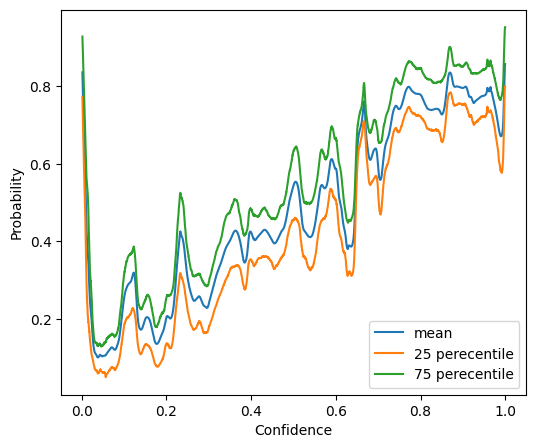

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
sn.lineplot(test_dfs[-1], x="Confidence", y="blue", label="mean", ax=ax)
sn.lineplot(test_dfs[-1], x="Confidence", y="quantile25_blue", label = "25 perecentile", ax=ax)
sn.lineplot(test_dfs[-1], x="Confidence", y="quantile75_blue", label = "75 perecentile", ax=ax)
ax.legend()
ax.set_ylabel("Probability")